# Preparation

In [63]:
import warnings
warnings.filterwarnings("ignore")

In [64]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [65]:
from sklearn.metrics.cluster import adjusted_rand_score

In [66]:
import STAGATE

In [67]:
# the location of R (used for the mclust clustering)
# os.environ['R_HOME'] = 'C:\Program Files\R\R-4.0.0'
# os.environ['R_USER'] = 'D:\ProgramData\Anaconda3\Lib\site-packages\rpy2'

In [68]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [69]:
section_id = '151676'

In [70]:
input_dir = os.path.join('Data/Tutorial1', section_id)
adata = sc.read_visium(path=input_dir, count_file=section_id+'_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

In [71]:
adata

AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [72]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [73]:
# read the annotation
Ann_df = pd.read_csv(os.path.join(input_dir, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']

In [74]:
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

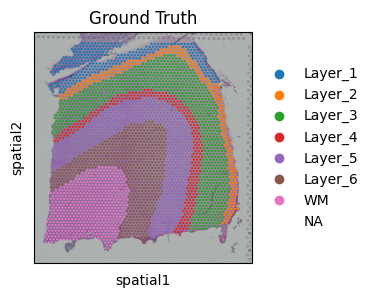

In [75]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

# Constructing the spatial network

------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.


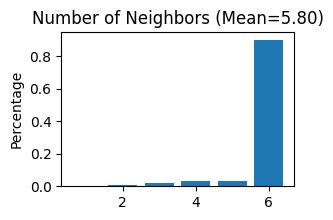

In [76]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=150)
STAGATE.Stats_Spatial_Net(adata)

In [ ]:
adata = STAGATE.train_STAGATE(adata, alpha=0)

Size of Input:  (3460, 3000)


2023-10-19 14:10:44.240118: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:4f:00.0
2023-10-19 14:10:44.240278: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory
2023-10-19 14:10:44.240326: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcublas.so.10.0'; dlerror: libcublas.so.10.0: cannot open shared object file: No such file or directory
2023-10-19 14:10:44.240364: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcufft.so.10.0'; dlerror: libcufft.so.10.0: cannot open shared object file: No such file or directory
2023-10-19 14:10:44.240402: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Cou

In [ ]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=7)

In [ ]:
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.2f' %ARI)

In [ ]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=["mclust", "Ground Truth"], title=['STAGATE (ARI=%.2f)'%ARI, "Ground Truth"])

In [ ]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, color=["mclust", "Ground Truth"], title=['STAGATE (ARI=%.2f)'%ARI, "Ground Truth"])

# Spatial trajectory inference (PAGA)

In [ ]:
used_adata = adata[adata.obs['Ground Truth']!='nan',]
used_adata

In [ ]:
sc.tl.paga(used_adata, groups='Ground Truth')

In [ ]:
plt.rcParams["figure.figsize"] = (4,3)
sc.pl.paga_compare(used_adata, legend_fontsize=10, frameon=False, size=20,
                   title=section_id+'_STGATE', legend_fontoutline=2, show=False)